# OpenPose(자세 추정)
화상에 포함된 여러 인물을 탐지하여 인체 각 부위 위치를 식별하고, 부위를 연결하는 선(링크)를 구하는 기술

- 'joint_self' : 목 이외 17개 부위의 x, y 좌표와 해당 부위 시인성 정보 포함
- 'scale_provided' : 주요 인물을 둘러싼 바운딩 박스 높이가 365pixel의 몇 배인지 나타냄
- 'joint_others' : 화상 내 다른 인물의 부위 정보 저장

### openpose를 활용한 자세 추정의 흐름 3단계!
1. 이미지 크기를 368*368 pixel로 변경하고, 색상 정보 표준화
2. 오픈포즈 신경망에 전처리 한 이미지 입력.
> 출력으로 19 * 368 * 368(클래스 수 * 높이 * 폭) 배열과 38 * 368 * 368 배열이 출력됨. 신체 부위 클래스와
PAFs 클래스에 대응하는 배열임. 배열의 채널 수는 신체 부위는 18개 + 기타 총 19채널, PAFs는 19개 링크 x,
y방향의 벡터 좌표를 나타내며 38채널이 됨. 배열에 저장되는 값은 각 픽셀이 각 클래스일 신뢰도(확률)에 대응한 값
3. 신체 부위의 출력 결과에서 각 부위별 좌표를 정하고, PAFs 정보와 함께 링크를 구함. 화상 크기를 다시 되돌림

In [2]:
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data
from pytorch_advanced.pose_estimation.utils.data_augumentation import *

In [3]:
# 파일 경로 리스트 작성
def make_datapath_list(rootpath) :
    '''학습 및 검증 이미지 데이터와 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트 작성'''
    
    # 어노테이션의 JSON 파일 읽기
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file :
        data_this = json.load(data_file)
        data_json = data_this['root']
        
    # index 저장
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples) :
        if data_json[count]['isValidation'] != 0 :
            val_indexes.append(count)
        else :
            train_indexes.append(count)
            
    # 이미지 파일 경로 저장
    train_img_list = list()
    val_img_list = list()
    
    for idx in train_indexes :
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)
        
    for idx in val_indexes : 
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)
        
    # 마스크 데이터 경로 지정
    train_mask_list = []
    val_mask_list = []
    
    for idx in train_indexes :
        img_idx = data_json[idx]['img_paths'][-16 : -4]
        anno_path = './pytorch_advanced/pose_estimation/data/mask/train2014_' + img_idx + '.jpg'
        train_mask_list.append(anno_path)
        
    for idx in val_indexes :
        img_idx = data_json[idx]['img_paths'][-16 : -4]
        anno_path = './pytorch_advanced/pose_estimation//data/mask/val2014/mask_COCO_val2014_' + img_idx + '.jpg'
        val_mask_list.append(anno_path)
        
    # 어노테이션 데이터 저장
    train_meta_list = list()
    val_meta_list = list()
    
    for idx in train_indexes :
        train_meta_list.append(data_json[idx])
        
    for idx in val_indexes :
        val_meta_list.append(data_json[idx])
        
    return train_img_list, train_mask_list ,val_img_list, val_mask_list, train_meta_list, val_meta_list

# 동작 확인
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
                                rootpath='./pytorch_advanced/pose_estimation/data/')

val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

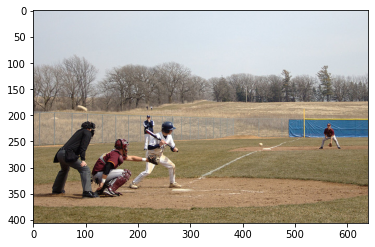

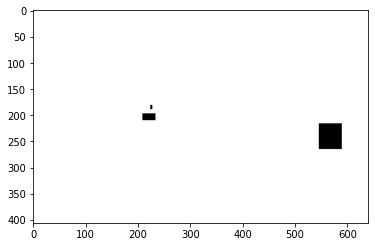

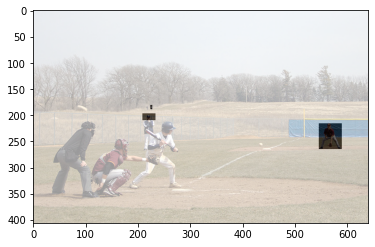

In [4]:
# 마스크 데이터 동작 확인
index = 24

# image
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

# 마스크
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 합성
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

---

## 이미지 전처리 작성
### DataTransform

- 화상과 어노테이션 전처리

In [5]:
class DataTransform() :
    '''화상과 마스크, 어노테이션의 전처리 클래스
        학습, 추론 시 서로 다르게 동작 
        학습 시에는 데이터 확장 수행'''
    
    def __init__(self) :
        
        self.data_transform = {
            'train' : Compose([
                get_anno(), # json에서 어노테이션을 사전에 저장
                add_neck(), # 어노테이션 데이터 순서 변경 및 목의 어노테이션 데이터 추가
                aug_scale(), # 확대 축소
                aug_rotate(), # 회전
                aug_croppad(), # 자르기
                aug_flip(), # 좌우 반전
                remove_illegal_joint(), # 화상에서 밀려나온 어노테이션 제거
                # Normalize_Tensor()   # 색상 정보의 표준화 및 텐서화
                no_Normalize_Tensor() # 색상 정보의 표준화 생략
            ]),
            'val' : Compose([
                # 검증 생략
            ])
        }
        
    def __call__(self, phase, meta_data, img, mask_miss) : 
        ''' 
        Parameters 
        -----------
        phase : `train` or `val` 
            전처리 모드 지정
        '''
        meta_data, img, mask_miss = self.data_transform[phase](meta_data, img, mask_miss)
        
        return meta_data, img, mask_miss

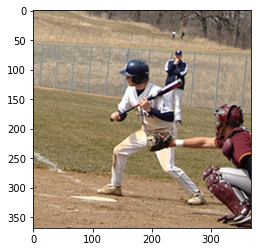

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


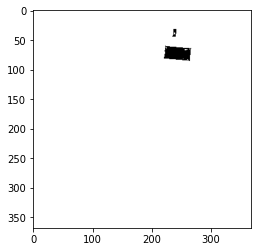

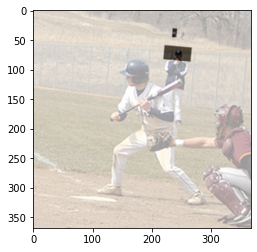

In [6]:
# 동작 확인
# 화상 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data =val_meta_list[index]

# 화상 전처리
transform = DataTransform()
meta_data ,img, mask_miss = transform('train', meta_data, img, mask_miss)

# 화상 표시
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# 마스크 표시
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 합성 RGB 정보 갖추기
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

### 어노테이션 데이터 작성
- 훈련 데이터 정답 정보로 사용할 어노테이션 데이터 작성

In [7]:
# from pytorch_advanced.pose_estimation.utils.dataloader import get_ground_truth
def get_ground_truth(meta, mask_miss):
    """アノテーションとマスクデータから正しい答えを求める"""

    # 初期設定
    params_transform = dict()
    params_transform['stride'] = 8  # 画像サイズを変更したくない場合は1にする
    params_transform['mode'] = 5
    params_transform['crop_size_x'] = 368
    params_transform['crop_size_y'] = 368
    params_transform['np'] = 56
    params_transform['sigma'] = 7.0
    params_transform['limb_width'] = 1.0

    stride = params_transform['stride']
    mode = params_transform['mode']
    crop_size_y = params_transform['crop_size_y']
    crop_size_x = params_transform['crop_size_x']
    num_parts = params_transform['np']
    nop = meta['numOtherPeople']

    # 画像サイズ
    grid_y = crop_size_y / stride
    grid_x = crop_size_x / stride
    channels = (num_parts + 1) * 2

    # 格納する変数
    heatmaps = np.zeros((int(grid_y), int(grid_x), 19))
    pafs = np.zeros((int(grid_y), int(grid_x), 38))

    mask_miss = cv2.resize(mask_miss, (0, 0), fx=1.0 / stride, fy=1.0 /
                           stride, interpolation=cv2.INTER_CUBIC).astype(
        np.float32)
    mask_miss = mask_miss / 255.
    mask_miss = np.expand_dims(mask_miss, axis=2)

    # マスク変数
    heat_mask = np.repeat(mask_miss, 19, axis=2)
    paf_mask = np.repeat(mask_miss, 38, axis=2)

    # ピンポイントの座標情報をガウス分布にぼやっとさせる
    for i in range(18):
        if (meta['joint_self'][i, 2] <= 1):
            center = meta['joint_self'][i, :2]
            gaussian_map = heatmaps[:, :, i]
            heatmaps[:, :, i] = putGaussianMaps(
                center, gaussian_map, params_transform)
        for j in range(nop):
            if (meta['joint_others'][j, i, 2] <= 1):
                center = meta['joint_others'][j, i, :2]
                gaussian_map = heatmaps[:, :, i]
                heatmaps[:, :, i] = putGaussianMaps(
                    center, gaussian_map, params_transform)
    # pafs
    mid_1 = [2, 9, 10, 2, 12, 13, 2, 3, 4,
             3, 2, 6, 7, 6, 2, 1, 1, 15, 16]

    mid_2 = [9, 10, 11, 12, 13, 14, 3, 4, 5,
             17, 6, 7, 8, 18, 1, 15, 16, 17, 18]

    thre = 1
    for i in range(19):
        # limb

        count = np.zeros((int(grid_y), int(grid_x)), dtype=np.uint32)
        if (meta['joint_self'][mid_1[i] - 1, 2] <= 1 and meta['joint_self'][mid_2[i] - 1, 2] <= 1):
            centerA = meta['joint_self'][mid_1[i] - 1, :2]
            centerB = meta['joint_self'][mid_2[i] - 1, :2]
            vec_map = pafs[:, :, 2 * i:2 * i + 2]
            #                    print vec_map.shape

            pafs[:, :, 2 * i:2 * i + 2], count = putVecMaps(centerA=centerA,
                                                            centerB=centerB,
                                                            accumulate_vec_map=vec_map,
                                                            count=count, params_transform=params_transform)
        for j in range(nop):
            if (meta['joint_others'][j, mid_1[i] - 1, 2] <= 1 and meta['joint_others'][j, mid_2[i] - 1, 2] <= 1):
                centerA = meta['joint_others'][j, mid_1[i] - 1, :2]
                centerB = meta['joint_others'][j, mid_2[i] - 1, :2]
                vec_map = pafs[:, :, 2 * i:2 * i + 2]
                pafs[:, :, 2 * i:2 * i + 2], count = putVecMaps(centerA=centerA,
                                                                centerB=centerB,
                                                                accumulate_vec_map=vec_map,
                                                                count=count, params_transform=params_transform)
    # background
    heatmaps[:, :, -
             1] = np.maximum(1 - np.max(heatmaps[:, :, :18], axis=2), 0.)

    # Tensorに
    heat_mask = torch.from_numpy(heat_mask)
    heatmaps = torch.from_numpy(heatmaps)
    paf_mask = torch.from_numpy(paf_mask)
    pafs = torch.from_numpy(pafs)

    return heat_mask, heatmaps, paf_mask, pafs

def putGaussianMaps(center, accumulate_confid_map, params_transform):
    '''ガウスマップに変換する'''
    crop_size_y = params_transform['crop_size_y']
    crop_size_x = params_transform['crop_size_x']
    stride = params_transform['stride']
    sigma = params_transform['sigma']

    grid_y = crop_size_y / stride
    grid_x = crop_size_x / stride
    start = stride / 2.0 - 0.5
    y_range = [i for i in range(int(grid_y))]
    x_range = [i for i in range(int(grid_x))]
    xx, yy = np.meshgrid(x_range, y_range)
    xx = xx * stride + start
    yy = yy * stride + start
    d2 = (xx - center[0]) ** 2 + (yy - center[1]) ** 2
    exponent = d2 / 2.0 / sigma / sigma
    mask = exponent <= 4.6052
    cofid_map = np.exp(-exponent)
    cofid_map = np.multiply(mask, cofid_map)
    accumulate_confid_map += cofid_map
    accumulate_confid_map[accumulate_confid_map > 1.0] = 1.0

    return accumulate_confid_map


def putVecMaps(centerA, centerB, accumulate_vec_map, count, params_transform):
    '''Parts A Fieldのベクトルを求める'''

    centerA = centerA.astype(float)
    centerB = centerB.astype(float)

    stride = params_transform['stride']
    crop_size_y = params_transform['crop_size_y']
    crop_size_x = params_transform['crop_size_x']
    grid_y = crop_size_y / stride
    grid_x = crop_size_x / stride
    thre = params_transform['limb_width']   # limb width
    centerB = centerB / stride
    centerA = centerA / stride

    limb_vec = centerB - centerA
    norm = np.linalg.norm(limb_vec)
    if (norm == 0.0):
        # print 'limb is too short, ignore it...'
        return accumulate_vec_map, count
    limb_vec_unit = limb_vec / norm
    # print 'limb unit vector: {}'.format(limb_vec_unit)

    # To make sure not beyond the border of this two points
    min_x = max(int(round(min(centerA[0], centerB[0]) - thre)), 0)
    max_x = min(int(round(max(centerA[0], centerB[0]) + thre)), grid_x)
    min_y = max(int(round(min(centerA[1], centerB[1]) - thre)), 0)
    max_y = min(int(round(max(centerA[1], centerB[1]) + thre)), grid_y)

    range_x = list(range(int(min_x), int(max_x), 1))
    range_y = list(range(int(min_y), int(max_y), 1))
    xx, yy = np.meshgrid(range_x, range_y)
    ba_x = xx - centerA[0]  # the vector from (x,y) to centerA
    ba_y = yy - centerA[1]
    limb_width = np.abs(ba_x * limb_vec_unit[1] - ba_y * limb_vec_unit[0])
    mask = limb_width < thre  # mask is 2D

    vec_map = np.copy(accumulate_vec_map) * 0.0
    vec_map[yy, xx] = np.repeat(mask[:, :, np.newaxis], 2, axis=2)
    vec_map[yy, xx] *= limb_vec_unit[np.newaxis, np.newaxis, :]

    mask = np.logical_or.reduce(
        (np.abs(vec_map[:, :, 0]) > 0, np.abs(vec_map[:, :, 1]) > 0))

    accumulate_vec_map = np.multiply(
        accumulate_vec_map, count[:, :, np.newaxis])
    accumulate_vec_map += vec_map
    count[mask == True] += 1

    mask = count == 0

    count[mask == True] = 1

    accumulate_vec_map = np.divide(accumulate_vec_map, count[:, :, np.newaxis])
    count[mask == True] = 0

    return accumulate_vec_map, count

In [8]:
# 이미지 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

# 이미지 전처리
meta_data, img, mask_miss = transform('train', meta_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# 오픈포즈 어노테이션 데이터 생성
heat_mask , heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# plt.imshow(img)
# plt.show()

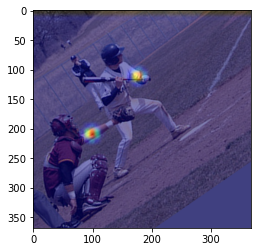

In [9]:
# 왼쪽 팔꿈치의 히트맵 확인

# 원본 이미지
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6] # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 주의 ! 히트맵은 이미지 크기가 1/8 로 되어있어 확대함

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0) 
# addWeighted() : brief Calculates the weighted sum of two arrays
plt.imshow(blend_img)
plt.show()

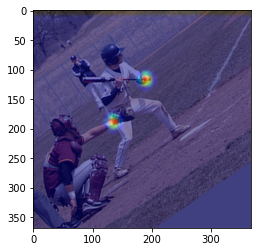

In [10]:
# 왼쪽 손목
heat_map = heatmaps[:, :, 7] # 7 은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map) * 255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

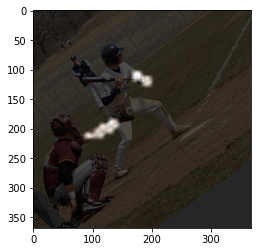

In [11]:
# 왼쪽 팔꿈치와 왼쪽 손목에 PAF 확인
paf = pafs[:, :, 24] # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성하여 표시
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()

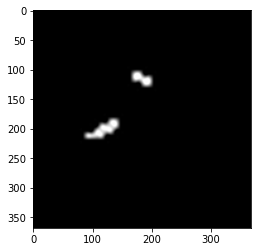

In [12]:
# PAF만 표시
paf = pafs[:, :, 24] # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)

### 데이터셋 작성
- COCOkeypointDataset

In [13]:
class COCOkeypointsDataset(data.Dataset) :
    '''
    MSCOCO Cocokeypoints의 데이터셋을 작성하는 클래스. 파이토치 데이터셋 클래스 상속
    
    Attributes
    -----------
    img_list : 리스트
        화상 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : `train` or `test` 
        학습 또는 훈련 설정
    transform : object
        전처리 클래스의 인스턴스
    '''
    
    def __init__(self, img_list, mask_list, meta_list, phase, transform) :
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase 
        self.transform = transform
        
    def __len__(self) :
        '''화상 매수 반환'''
        return len(self.img_list)
    
    def __getitem__(self, index) :
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask
    
    def pull_item(self, index) :
        '''화상의 텐서 형식 데이터, 어노테이션, 마스크 취득'''
        
        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이] [폭] [색BGR]
        
        # 2. 마스크와 어노테이션 읽기
        mask_miss = cv2.imread(self.mask_list[index])
        meta_data = self.meta_list[index]
        
        # 3. 화상 전처리
        meta_data, img, mask_miss = self.transform(self.phase, meta_data, img, mask_miss)
        
        # 4. 정답 어노테이션 데이터 취득
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss_numpy)
        
        # 5. 마스크 데이터는 RGB가 (1, 1, 1) 또는 (0, 0, 0)이므로 차원을 낮춤
        # 마스크된 위치는 값이 0, 그렇지 않으면 1
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]
        
        # 6. 채널이 맨 끝에 있어 순서 변경
        # 예) paf_mask : torch.Size([46, 46, 38])
        # --> torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)
        
        return img, heatmaps, heat_mask, pafs, paf_mask

In [14]:
# 동작 확인
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())


# 데이터 꺼내기 예시
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


- 데이터 로더 작성

In [15]:
# 데이터 로더
batch_size = 8

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {'train' : train_dataloader , 'val' : val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict['train']) # 반복으로 변환
item = next(batch_iterator) # 첫번째 요소를 꺼낸다
print(item[0].shape) # img
print(item[1].shape) # heatmaps
print(item[2].shape) # heat_mask
print(item[3].shape) # pafs
print(item[4].shape) # paf_mask

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])


---

## OpenPose 네트워크 구현

- 총 7개 모듈로 구성
- `Feature` : 화상의 특징량 추출
> VGG-19를 사용하여 출력되는 화상 크기는 1/8이 됨. Feature 모듈의 출력은 128 * 46 * 46

- `Stage` : 히트맵과 PAFs를 출력 (6개)
> stage 1은 Feature 모듈 출력을 2개의 서브 네트워크에 입력(block1_1, block1_2). block1_1은 PAFs를 출력하는 서브 네트워크, 블록 1_2는 히트맵을 출력하는 서브 네트워크. 블록1_1의 출력 텐서 크기는 38 * 46 * 46, 블록1_2의 출력 텐서 크기는 19 * 46 * 46 
> stage 2의 블록 2_1과 2_2에 stage 1의 출력 텐서(185 * 46 * 46)를 입력. 2_1과 2_2는 PAFs(38 * 46 * 46)와 히트맵(19 * 46 * 46)을 출력.
스테이지 6까지 반복 --> 최종 서브 블록 6_1은 PAFs(38 * 46 * 46), 6_2는 히트맵(19 * 46 * 46)을 출력

In [16]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision

In [17]:
class OpenPoseNet(nn.Module) :
    def __init__(self) :
        super(OpenPoseNet, self).__init__()
        
        # Feature 모듈
        self.model0 = OpenPose_Feature()
        
        # Stage 모듈
        # PAFs 측
        self.model1_1 = make_OpenPose_block('block1_1')
        self.model2_1 = make_OpenPose_block('block2_1')        
        self.model3_1 = make_OpenPose_block('block3_1')        
        self.model4_1 = make_OpenPose_block('block4_1')        
        self.model5_1 = make_OpenPose_block('block5_1')        
        self.model6_1 = make_OpenPose_block('block6_1')
        
        # confidence heatmap 측
        self.model1_2 = make_OpenPose_block('block1_2')
        self.model2_2 = make_OpenPose_block('block2_2')        
        self.model3_2 = make_OpenPose_block('block3_2')        
        self.model4_2 = make_OpenPose_block('block4_2')        
        self.model5_2 = make_OpenPose_block('block5_2')        
        self.model6_2 = make_OpenPose_block('block6_2')        
        
    def forward(self, x) :
        ''' 순전파 정의 '''
        
        # Feature 모듈
        out1 = self.model0(x)
        
        # stage 1
        out1_1 = self.model1_1(out1) # PAFs 측
        out1_2 = self.model1_2(out1) # confidence heatmap 측   
        
        # stage 2
        out2 = torch.cat([out1_1, out1_2, out1], 1) # 1차원 채널 결합
        out2_1 = self.model2_1(out2) 
        out2_2 = self.model2_2(out2)
        
        # stage 3
        out3 = torch.cat([out2_1, out2_2, out1], 1) # 1차원 채널 결합
        out3_1 = self.model3_1(out3) 
        out3_2 = self.model3_2(out3)   
        
        # stage 4
        out4 = torch.cat([out3_1, out3_2, out1], 1) # 1차원 채널 결합
        out4_1 = self.model4_1(out4) 
        out4_2 = self.model4_2(out4)   
        
        # stage 5
        out5 = torch.cat([out4_1, out4_2, out1], 1) # 1차원 채널 결합
        out5_1 = self.model5_1(out5) 
        out5_2 = self.model5_2(out5)   
        
        # stage 6
        out6 = torch.cat([out5_1, out5_2, out1], 1) # 1차원 채널 결합
        out6_1 = self.model6_1(out6) 
        out6_2 = self.model6_2(out6)   
        
        # 손실 계산을 위해 각 스테이지의 결과를 저장
        saved_for_loss = []
        saved_for_loss.append(out1_1) # PAFs 측
        saved_for_loss.append(out1_2) # confidence heatmap 측
        saved_for_loss.append(out2_1)
        saved_for_loss.append(out2_2)
        saved_for_loss.append(out3_1)
        saved_for_loss.append(out3_2)
        saved_for_loss.append(out4_1)
        saved_for_loss.append(out4_2)
        saved_for_loss.append(out5_1)
        saved_for_loss.append(out5_2)
        saved_for_loss.append(out6_1)
        saved_for_loss.append(out6_2)
        
        # 최종적 PAFs의 out6_1과 confidence heatmap의 out6_2,
        # 손실 계산용으로 각 단계에서 PAFs와 히트맵을 저장한 saved_for_loss를 출력
        # out6_1 : torch.Size([minibatch, 38, 46, 46])
        # out6_12: torch.Size([minibatch, 19, 46, 46])        
        # saved_for_loss : [out1_1, out1_2, ..., out6_2]
        
        return (out6_1, out6_2), saved_for_loss

### Feature 및 Stage 모듈 설명 및 구현

In [18]:
class OpenPose_Feature(nn.Module) :
    def __init__(self) :
        super(OpenPose_Feature, self).__init__()
        
        # VGG-19 최초 열 개 합성곱 사용
        # 처음 실행할 때는 학습된 파라미터를 다운로드하여 실행에 시간이 걸림
        vgg19 = torchvision.models.vgg19(pretrained=True)
        model = {}
        model['block0'] = vgg19.features[:23] # VGG-19 최초 열개의 합성곱 층까지
        
        # 나머지는 새로운 합성곱 층을 두개 준비
        model['block0'].add_module('23', torch.nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module('24', torch.nn.ReLU(inplace=True))
        model['block0'].add_module('25', torch.nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module('26', torch.nn.ReLU(inplace=True))
        
        self.model = model['block0']
        
    def forward(self, x) :
            outputs = self.model(x)
            return outputs

In [19]:
'''
**********************************************
make_OpenPose_block 함수는 다음 네 가지를 실행
**********************************************
(1) 서브 네트워크를 구성하는 유닛 설정인 config 설정
-->사전형 변술 합성곱 층을 리스트로 설정
-->전체 스테이지 및 블록 구성을 준비하여 주어진 인수의 
block_name 설정을 사용
(2) config 내용에 맞도록 합성곱 층과 ReLU를 생성하고 리스트
변수 layers에 저장.
(3) 리스트 변수 layers의 유닛 정보를 사용하여 nn.Sequential()
클래스의 네트워크 모델 net을 생성.
(4) 변수 net의 합성곱 층 가중치 초기화
**********************************************
'''

def make_OpenPose_block(block_name) : 
    '''
    구성 변수에서 오픈포즈 stage 모듈의 블록 작성
    nn.Module이 아닌 nn.Sequential로 한다'''
    
    # 1. 구성의 사전형 변수 blocks를 작성하여 네트워크 생성
    # 모든 패턴의 사전을 준비하여 block_name 인수만 생성
    blocks = {}
    # stage 1
    blocks['block1_1'] = [{'conv5_1_CPM_L1' : [128, 128, 3, 1, 1]},
                        {'conv5_2_CPM_L1' : [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1' : [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1' : [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1' : [512, 38, 1, 1, 0]}]
    
    blocks['block1_2'] = [{'conv5_1_CPM_L2' : [128, 128, 3, 1, 1]},
                         {'conv5_2_CPM_L2' : [128, 128, 3, 1, 1]},
                         {'conv5_3_CPM_L2' : [128, 128, 3, 1, 1]},
                         {'conv5_4_CPM_L2' : [128, 512, 1, 1, 0]},
                         {'conv5_5_CPM_L2' : [512, 19, 1, 1, 0]}]
    
    # stage 2 ~ 6 // 반복
    for i in range(2, 7) :
        blocks['block%d_1'% i] = [
            {'Mconv1_stage%d_L1' % i : [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i : [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i : [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L1' % i : [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L1' % i : [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i : [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i : [128, 38, 1, 1, 0]}]
        
        blocks['block%d_2'% i] = [
            {'Mconv1_stage%d_L2' % i : [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i : [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i : [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L2' % i : [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L2' % i : [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i : [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i : [128, 19, 1, 1, 0]}]
        
    # block name 인수의 구성 사전을 꺼낸다.
    cfg_dict = blocks[block_name]
    
    # 구성 내용을 리스트 변수 layers에 저장
    layers = []
    
    # 0번째부터 마지막 층까지 작성
    for i in range(len(cfg_dict)) : 
        for k, v in cfg_dict[i].items() :
            if 'pool' in k :
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                       padding=v[2])]
            else :
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                  kernel_size=v[2], stride=v[3],
                                  padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]
                
    # 3. layers를 Sequential로 한다.
    # 단, 마지막에 있는 ReLU는 필요 없어 직전 까지 사용
    net = nn.Sequential(*layers[:-1])
    
    # 4. 초기화 함수를 설정하여 합성곱층 초기화
    def _initialize_weights_norm(self) :
        for m in self.modules() :
            if isinstance(m, nn.Conv2d) :
                init.normal_(m.weight, std=0.01)
                if m.bias is not None :
                    init.constant_(m.bias, 0.0)
        
    net.apply(_initialize_weights_norm)
        
    return net

In [20]:
# 동작 확인

# 모델 정의
net = OpenPoseNet()
net.train()

# 더미 데이터 작성
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 계산
outputs = net(dummy_img)
print(outputs)

((tensor([[[[ 9.4350e-06,  4.7697e-06,  2.2350e-05,  ...,  2.3385e-05,
           -1.0775e-05, -2.5421e-05],
          [ 3.3316e-05,  1.5745e-05,  3.2004e-05,  ...,  9.5430e-06,
           -7.4230e-06,  2.9641e-06],
          [ 7.7257e-07,  2.6277e-05,  2.7083e-05,  ...,  3.2388e-05,
           -2.7159e-05, -1.4061e-05],
          ...,
          [-2.3759e-06,  1.2394e-05,  3.2214e-05,  ...,  7.2978e-05,
            5.5372e-05,  2.0190e-05],
          [ 2.4127e-05,  3.6204e-05,  3.4982e-05,  ...,  5.0861e-05,
            7.6319e-05,  1.0749e-05],
          [ 1.1770e-05,  2.3526e-05,  1.1862e-05,  ...,  5.5651e-05,
            4.6704e-05, -1.8684e-06]],

         [[-2.2397e-05,  3.2217e-05,  1.8615e-05,  ..., -1.0168e-05,
            2.1550e-05,  1.4139e-05],
          [-2.1465e-05, -6.3650e-06,  2.8374e-05,  ...,  1.9740e-06,
           -3.1313e-06, -2.0533e-05],
          [-1.4237e-05,  1.0633e-05,  4.9699e-05,  ..., -3.4979e-05,
           -7.2371e-06, -1.1129e-05],
          ...,
   

---

## 텐서보드X를 이용한 네트워크 시각화
> `텐서보드 X` : 파이토치 데이터나 네트워크 모델을 시각화하는 서드파티 패키지

In [21]:
# !pip install tensorflow
# !pip install tensorboardx

### Graph 파일 생성
시각화하려는 네트워크 모델 파일 생성. // 지금까지 작성한 openpose 네트워크 모델의 인스턴스 생성

In [22]:
# 모델 준비
net = OpenPoseNet()
net.train()

OpenPoseNet(
  (model0): OpenPose_Feature(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, ker

In [23]:
# Tensorboard X의 저장 클래스 호출
from tensorboardX import SummaryWriter

# 2. tbX 폴더에 저장할 writer 준비
# tbX 폴더가 없으면 자동으로 생성
writer = SummaryWriter('./tbX/')

# 3. 네트워크에 넣을 더미 데이터 생성
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 4. 오픈포즈의 인스턴스 net에 더미 데이터인 dummy_img를 전달할 때 graph를 writer에 저장
writer.add_graph(net, (dummy_img,))
writer.close()

# 5. 명령 프롬프트를 열고 tbX가 있는 4_pose_estimation 폴더까지 이동
# 다음 명령 실행

# tensorbard --logdir='./tbX/'

# 이후 http://localhost:6006에 접근

---

## 오픈포즈 학습

### 데이터로더 및 네트워크 작성

In [24]:
# MSCOCO 파일 경로 리스트 작성
train_img_list , train_mask_list, val_img_list ,\
val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath='./pytorch_advanced/pose_estimation/data/')

# 데이터셋 작성
# 데이터 양이 많아 train을 val_list에서 작성
train_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list,
                                    phase='train', transform=DataTransform())

# 간단한 학습을 진행 // 검증 생략
# val_dataset = CocokeypointsDataset(val_img_list, val_mask_list, val_meta_list,
#                                     phase='val', transform=DataTransform())

# 데이터 로더 작성
batch_size = 32

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 사전 형 변수로 정리
# dataloaders_dict = {'train' : train_dataloader, 'val' : val_dataloader}
dataloaders_dict = {'train' : train_dataloader, 'val' : None}

# OpenPose Net 클래스의 인스턴스 생성
net = OpenPoseNet()

### 손실함수 정의
- 오픈포즈의 손실함수는 회귀 문제에서 일반적으로 사용하는 평균제곱오차함수로 하고, 
구현 시에는 F.mse_loss()를 사용함
- 자세 어노테이션이 없는 부분은 손실을 계산하지 않음

In [25]:
# 손실함수 설정
class OpenPoseLoss(nn.Module) :
    '''오픈포즈의 손실 함수 클래스'''
    
    def __init__(self) :
        super(OpenPoseLoss, self).__init__()
        
    def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask) :
        '''
        손실함수 계산
        Parameters
        -----------
        saved_for_loss : OpenPoseNet 출력 (리스트)
        
        heatmap_target : [num_batch, 19, 46, 46 ]
            정답 부위의 어노테이션 정보
            
        heatmap_mask : [num_batch, 19, 46, 46]
            히트맵 화상의 마스크
            
        paf_target : [num_batch, 38, 46, 46 ]
            정답 PAF의 어노테이션 정보
            
        paf_mask : [num_batch, 38, 46, 46 ]
            PAF 화상의 마스크
            
        Returns
        ------
        loss : 텐서
            손실 값
        '''
        
        total_loss = 0
        # 스테이지 마다 계산
        for j in range(6) :
            
            # PAFs 및 히트맵에서 마스크된 부분(paf_mask=0) 은 무시
            # PAFs
            pred1 = saved_for_loss[2 * j] * paf_mask
            gt1 = paf_target.float() * paf_mask
            
            # 히트맵
            pred2 = saved_for_loss[2 *j +1] * heat_mask
            gt2 = heatmap_target.float() * heat_mask
            
            total_loss += F.mse_loss(pred1, gt1, reduction='mean') + \
                    F.mse_loss(pred2, gt2, reduction='mean')
            
        return total_loss

criterion = OpenPoseLoss()

### 학습 실시

In [26]:
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [47]:
import time
optimizer = optim.SGD(net.parameters(), lr=1e-2,
                     momentum=0.9,
                     weight_decay=0.0001)

# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs) :
    
    # GPU를 사용할 수 있는지 확인
    device= torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
    print('사용 장치:', device)
    
    # 네트워크를 GPU로
    net.to(device)
    
    # 네트워크가 어느정도 고정되면 고속화시킨다
    torch.backends.cudnn.benchmark = True
    
    # 화상 매수
    num_train_imgs = len(dataloaders_dict['train'].dataset)
    batch_size = dataloaders_dict['train'].batch_size
    
    # 반복 카운터 설정
    iteration = 1
    
    # 에폭 루프
    for epoch in range(num_epochs) :
        
        # 개시 시간 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0 # 에폭 손실 합
        epoch_val_loss = 0.0 # 에폭 손실 합
        
        print('-' * 20)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        
        # 에폭별 훈련 및 검증 루프
        for phase in ['train', 'val'] :
            if phase == 'train' :
                net.train() # 모델을 훈련 모드로
                optimizer.zero_grad()
                print(' (train) ')
                
            # 검증 생략
            else :
                continue
#               net.eval() # 모델 검증 모드
#               print(' (val) ')
            
            # 데이터 로더에서 미니 배치씩 꺼내는 루프
            for images, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase] :
                # 미니 배치 크기가 1이면 배치 정규화에서 오류가 발생하므로 피한다
#                 if images.size()[0] == 1 :
#                     continue

                # GPU를 사용할 수 있으면 GPU로 데이터를 보낸다.
                images = images.to(device)
                heatmap_target = heatmap_target.to(device)
                heat_mask = heat_mask.to(device)
                paf_target = paf_target.to(device)
                paf_mask = paf_mask.to(device)

                # 옵티마잊더 초기화
                optimizer.zero_grad()

                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train') :
                    # out6_1, out6_2는 사용하지 않으므로 _ 로 대체
                    _, saved_for_loss = net(images)

                    loss = criterion(saved_for_loss, heatmap_target, 
                                    heat_mask, paf_target, paf_mask)

                    del saved_for_loss

                    # 훈련 시 역전파
                    if phase == 'train' :
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0 ) : #10iter에 한 번 손실 표시
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print(f'반복 {iteration} || Loss : \
                                  {loss.item()/batch_size:.4f} || 10iter : {duration:.4f} sec.')
                            t_iter_start = time.time()

                        epoch_tran_loss += loss.item()
                        iteration += 1
                    
            # 에폭의 phase 별 손실과 정답률
            t_epoch_finish = time.time()
            print('-' * 20)
            print(f'Epoch {epoch + 1} || Epoch Train Loss : \
            {epoch_train_loss/num_train_imgs:.4f} || Epoch Val Loss : {0:.4f}')
            print(f'timer : {t_epoch_finish - t_epoch_start:.4f} sec')
            t_epoch_start = time.time()
        
    # 마지막 네트워크 저장
    torch.save(net.state_dict(), './pytorch_advanced/pose_estimation/weights/openpose_net_' + \
              str(epoch+1) + '.pth')

In [48]:
# 학습 및 검증 실행
num_epochs = 2

train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

사용 장치: cpu
--------------------
Epoch 1/2
--------------------
 (train) 


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:62] data. DefaultCPUAllocator: not enough memory: you tried to allocate %dGB. Buy new RAM!2


---

## 오픈포즈 추론

In [29]:
# 학습된 모델과 이번 장의 모델은 네트워크 계층의 이름이 달라 대응시켜 로드함
# 모델 정의
net = OpenPoseNet()

# 학습된 파라미터를 읽는다
net_weights = torch.load('./pytorch_advanced/pose_estimation/weights/pose_model_scratch.pth', map_location='cpu')
keys = list(net_weights.keys())

weights_load = {}

# 로드한 내용을 책에서 구축한 모델의 파라미터명 net.state_dict().keys()로 복사
for i in range(len(keys)) :
    weights_load[list(net.state_dict().keys())[i]] = net_weights[list(keys)[i]]
    
# 복사한 내용을 모델에 할당
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('네트워크 설정 완료. 학습된 가중치를 로드했습니다.')

네트워크 설정 완료. 학습된 가중치를 로드했습니다.


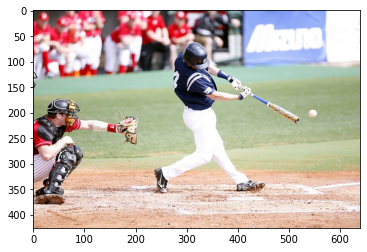

In [32]:
# 야구 화상을 읽어 전처리 실행
test_image = './pytorch_advanced/pose_estimation/data/hit-1407826_640.jpg'
ori_image = cv2.imread(test_image) # B, G, R 순서

# BGR을 RGB로 표시
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
plt.imshow(ori_image)
plt.show()

# 화상 resize
size = (368, 268)
img = cv2.resize(ori_image, size, interpolation=cv2.INTER_CUBIC)

# 화상 전처리
img = img.astype(np.float32) / 255.

# 색상 정보 표준화
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:, :, ::-1] # BGR --> RGB

for i in range(3) :
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]
    
# (높이, 폭, 색) --> (색, 높이, 폭)
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 화상을 텐서로
img = torch.from_numpy(img)

# 미니 배치화 : torch.Size([1, 3, 368, 368])

x = img.unsqueeze(0)

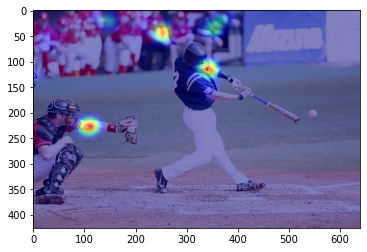

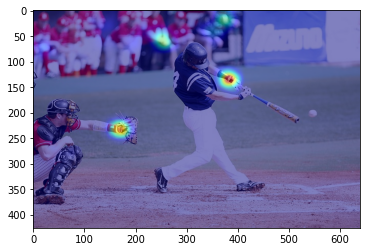

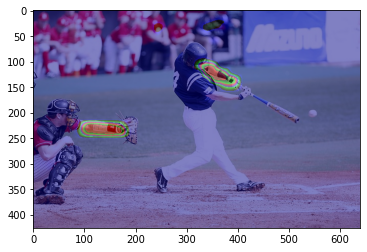

In [34]:
# 오픈포즈로 히트맵과 PAFs를 구한다
net.eval()

predicted_outputs, _ = net(x)

# 화상을 텐서에서 넘파이로 변환하여 크기 반환
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (ori_image.shape[1], ori_image.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (ori_image.shape[1], ori_image.shape[0]), interpolation=cv2.INTER_CUBIC)

# 왼쪽 팔꿈치와 왼쪽 손목의 히트맵, 그리고 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터를 시각화
# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6] # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성하여 표시
blend_img = cv2.addWeighted(ori_image, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 왼쪽 손목
heat_map = heatmaps[:, :, 7] # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 합성하여 표시
blend_img = cv2.addWeighted(ori_image, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 왼쪽 팔꿈치와 왼쪽 손목을 잇는 PAF의 x 벡터
paf = pafs[:, : , 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)* 266))
paf = np.asarray(paf.convert('RGB'))

# 합성하여 표시
blend_img = cv2.addWeighted(ori_image, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [35]:
# 第4章姿勢推定のネットワーク
# 以下を一部変更し、ほぼそのまま使用
# https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation/blob/master/network/post.py
# Released under the MIT license


# 必要なパッケージのimport
import math

import cv2
import matplotlib.cm
import numpy as np
from scipy.ndimage.filters import gaussian_filter, maximum_filter
from scipy.ndimage.morphology import generate_binary_structure

# It is better to use 0.1 as threshold when evaluation, but 0.3 for demo
# purpose.
cmap = matplotlib.cm.get_cmap('hsv')

# Heatmap indices to find each limb (joint connection). Eg: limb_type=1 is
# Neck->LShoulder, so joint_to_limb_heatmap_relationship[1] represents the
# indices of heatmaps to look for joints: neck=1, LShoulder=5
joint_to_limb_heatmap_relationship = [
    [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10],
    [1, 11], [11, 12], [12, 13], [1, 0], [0, 14], [14, 16], [0, 15], [15, 17],
    [2, 16], [5, 17]]

# PAF indices containing the x and y coordinates of the PAF for a given limb.
# Eg: limb_type=1 is Neck->LShoulder, so
# PAFneckLShoulder_x=paf_xy_coords_per_limb[1][0] and
# PAFneckLShoulder_y=paf_xy_coords_per_limb[1][1]
paf_xy_coords_per_limb = [
    [12, 13], [20, 21], [14, 15], [16, 17], [22, 23],
    [24, 25], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [28, 29],
    [30, 31], [34, 35], [32, 33], [36, 37], [18, 19], [26, 27]]

# Color code used to plot different joints and limbs (eg: joint_type=3 and
# limb_type=3 will use colors[3])
colors = [
    [255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0],
    [85, 255, 0], [0, 255, 0], [0, 255, 85], [0, 255, 170], [0, 255, 255],
    [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], [170, 0, 255],
    [255, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 0]]

NUM_JOINTS = 18
NUM_LIMBS = len(joint_to_limb_heatmap_relationship)


def find_peaks(param, img):
    """
    Given a (grayscale) image, find local maxima whose value is above a given
    threshold (param['thre1'])
    :param img: Input image (2d array) where we want to find peaks
    :return: 2d np.array containing the [x,y] coordinates of each peak found
    in the image
    """

    peaks_binary = (maximum_filter(img, footprint=generate_binary_structure(
        2, 1)) == img) * (img > param['thre1'])
    # Note reverse ([::-1]): we return [[x y], [x y]...] instead of [[y x], [y
    # x]...]
    return np.array(np.nonzero(peaks_binary)[::-1]).T


def compute_resized_coords(coords, resizeFactor):
    """
    Given the index/coordinates of a cell in some input array (e.g. image),
    provides the new coordinates if that array was resized by making it
    resizeFactor times bigger.
    E.g.: image of size 3x3 is resized to 6x6 (resizeFactor=2), we'd like to
    know the new coordinates of cell [1,2] -> Function would return [2.5,4.5]
    :param coords: Coordinates (indices) of a cell in some input array
    :param resizeFactor: Resize coefficient = shape_dest/shape_source. E.g.:
    resizeFactor=2 means the destination array is twice as big as the
    original one
    :return: Coordinates in an array of size
    shape_dest=resizeFactor*shape_source, expressing the array indices of the
    closest point to 'coords' if an image of size shape_source was resized to
    shape_dest
    """

    # 1) Add 0.5 to coords to get coordinates of center of the pixel (e.g.
    # index [0,0] represents the pixel at location [0.5,0.5])
    # 2) Transform those coordinates to shape_dest, by multiplying by resizeFactor
    # 3) That number represents the location of the pixel center in the new array,
    # so subtract 0.5 to get coordinates of the array index/indices (revert
    # step 1)
    return (np.array(coords, dtype=float) + 0.5) * resizeFactor - 0.5


def NMS(param, heatmaps, upsampFactor=1., bool_refine_center=True, bool_gaussian_filt=False):
    """
    NonMaximaSuppression: find peaks (local maxima) in a set of grayscale images
    :param heatmaps: set of grayscale images on which to find local maxima (3d np.array,
    with dimensions image_height x image_width x num_heatmaps)
    :param upsampFactor: Size ratio between CPM heatmap output and the input image size.
    Eg: upsampFactor=16 if original image was 480x640 and heatmaps are 30x40xN
    :param bool_refine_center: Flag indicating whether:
     - False: Simply return the low-res peak found upscaled by upsampFactor (subject to grid-snap)
     - True: (Recommended, very accurate) Upsample a small patch around each low-res peak and
     fine-tune the location of the peak at the resolution of the original input image
    :param bool_gaussian_filt: Flag indicating whether to apply a 1d-GaussianFilter (smoothing)
    to each upsampled patch before fine-tuning the location of each peak.
    :return: a NUM_JOINTS x 4 np.array where each row represents a joint type (0=nose, 1=neck...)
    and the columns indicate the {x,y} position, the score (probability) and a unique id (counter)
    """
    # MODIFIED BY CARLOS: Instead of upsampling the heatmaps to heatmap_avg and
    # then performing NMS to find peaks, this step can be sped up by ~25-50x by:
    # (9-10ms [with GaussFilt] or 5-6ms [without GaussFilt] vs 250-280ms on RoG
    # 1. Perform NMS at (low-res) CPM's output resolution
    # 1.1. Find peaks using scipy.ndimage.filters.maximum_filter
    # 2. Once a peak is found, take a patch of 5x5 centered around the peak, upsample it, and
    # fine-tune the position of the actual maximum.
    #  '-> That's equivalent to having found the peak on heatmap_avg, but much faster because we only
    #      upsample and scan the 5x5 patch instead of the full (e.g.) 480x640

    joint_list_per_joint_type = []
    cnt_total_joints = 0

    # For every peak found, win_size specifies how many pixels in each
    # direction from the peak we take to obtain the patch that will be
    # upsampled. Eg: win_size=1 -> patch is 3x3; win_size=2 -> 5x5
    # (for BICUBIC interpolation to be accurate, win_size needs to be >=2!)
    win_size = 2

    for joint in range(NUM_JOINTS):
        map_orig = heatmaps[:, :, joint]
        peak_coords = find_peaks(param, map_orig)
        peaks = np.zeros((len(peak_coords), 4))
        for i, peak in enumerate(peak_coords):
            if bool_refine_center:
                x_min, y_min = np.maximum(0, peak - win_size)
                x_max, y_max = np.minimum(
                    np.array(map_orig.T.shape) - 1, peak + win_size)

                # Take a small patch around each peak and only upsample that
                # tiny region
                patch = map_orig[y_min:y_max + 1, x_min:x_max + 1]
                map_upsamp = cv2.resize(
                    patch, None, fx=upsampFactor, fy=upsampFactor, interpolation=cv2.INTER_CUBIC)

                # Gaussian filtering takes an average of 0.8ms/peak (and there might be
                # more than one peak per joint!) -> For now, skip it (it's
                # accurate enough)
                map_upsamp = gaussian_filter(
                    map_upsamp, sigma=3) if bool_gaussian_filt else map_upsamp

                # Obtain the coordinates of the maximum value in the patch
                location_of_max = np.unravel_index(
                    map_upsamp.argmax(), map_upsamp.shape)
                # Remember that peaks indicates [x,y] -> need to reverse it for
                # [y,x]
                location_of_patch_center = compute_resized_coords(
                    peak[::-1] - [y_min, x_min], upsampFactor)
                # Calculate the offset wrt to the patch center where the actual
                # maximum is
                refined_center = (location_of_max - location_of_patch_center)
                peak_score = map_upsamp[location_of_max]
            else:
                refined_center = [0, 0]
                # Flip peak coordinates since they are [x,y] instead of [y,x]
                peak_score = map_orig[tuple(peak[::-1])]
            peaks[i, :] = tuple([int(round(x)) for x in compute_resized_coords(
                peak_coords[i], upsampFactor) + refined_center[::-1]]) + (peak_score, cnt_total_joints)
            cnt_total_joints += 1
        joint_list_per_joint_type.append(peaks)

    return joint_list_per_joint_type


def find_connected_joints(param, paf_upsamp, joint_list_per_joint_type, num_intermed_pts=10):
    """
    For every type of limb (eg: forearm, shin, etc.), look for every potential
    pair of joints (eg: every wrist-elbow combination) and evaluate the PAFs to
    determine which pairs are indeed body limbs.
    :param paf_upsamp: PAFs upsampled to the original input image resolution
    :param joint_list_per_joint_type: See 'return' doc of NMS()
    :param num_intermed_pts: Int indicating how many intermediate points to take
    between joint_src and joint_dst, at which the PAFs will be evaluated
    :return: List of NUM_LIMBS rows. For every limb_type (a row) we store
    a list of all limbs of that type found (eg: all the right forearms).
    For each limb (each item in connected_limbs[limb_type]), we store 5 cells:
    # {joint_src_id,joint_dst_id}: a unique number associated with each joint,
    # limb_score_penalizing_long_dist: a score of how good a connection
    of the joints is, penalized if the limb length is too long
    # {joint_src_index,joint_dst_index}: the index of the joint within
    all the joints of that type found (eg: the 3rd right elbow found)
    """
    connected_limbs = []

    # Auxiliary array to access paf_upsamp quickly
    limb_intermed_coords = np.empty((4, num_intermed_pts), dtype=np.intp)
    for limb_type in range(NUM_LIMBS):
        # List of all joints of type A found, where A is specified by limb_type
        # (eg: a right forearm starts in a right elbow)
        joints_src = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][0]]
        # List of all joints of type B found, where B is specified by limb_type
        # (eg: a right forearm ends in a right wrist)
        joints_dst = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][1]]
        if len(joints_src) == 0 or len(joints_dst) == 0:
            # No limbs of this type found (eg: no right forearms found because
            # we didn't find any right wrists or right elbows)
            connected_limbs.append([])
        else:
            connection_candidates = []
            # Specify the paf index that contains the x-coord of the paf for
            # this limb
            limb_intermed_coords[2, :] = paf_xy_coords_per_limb[limb_type][0]
            # And the y-coord paf index
            limb_intermed_coords[3, :] = paf_xy_coords_per_limb[limb_type][1]
            for i, joint_src in enumerate(joints_src):
                # Try every possible joints_src[i]-joints_dst[j] pair and see
                # if it's a feasible limb
                for j, joint_dst in enumerate(joints_dst):
                    # Subtract the position of both joints to obtain the
                    # direction of the potential limb
                    limb_dir = joint_dst[:2] - joint_src[:2]
                    # Compute the distance/length of the potential limb (norm
                    # of limb_dir)
                    limb_dist = np.sqrt(np.sum(limb_dir**2)) + 1e-8
                    limb_dir = limb_dir / limb_dist  # Normalize limb_dir to be a unit vector

                    # Linearly distribute num_intermed_pts points from the x
                    # coordinate of joint_src to the x coordinate of joint_dst
                    limb_intermed_coords[1, :] = np.round(np.linspace(
                        joint_src[0], joint_dst[0], num=num_intermed_pts))
                    limb_intermed_coords[0, :] = np.round(np.linspace(
                        joint_src[1], joint_dst[1], num=num_intermed_pts))  # Same for the y coordinate
                    intermed_paf = paf_upsamp[limb_intermed_coords[0, :],
                                              limb_intermed_coords[1, :], limb_intermed_coords[2:4, :]].T

                    score_intermed_pts = intermed_paf.dot(limb_dir)
                    score_penalizing_long_dist = score_intermed_pts.mean(
                    ) + min(0.5 * paf_upsamp.shape[0] / limb_dist - 1, 0)
                    # Criterion 1: At least 80% of the intermediate points have
                    # a score higher than thre2
                    criterion1 = (np.count_nonzero(
                        score_intermed_pts > param['thre2']) > 0.8 * num_intermed_pts)
                    # Criterion 2: Mean score, penalized for large limb
                    # distances (larger than half the image height), is
                    # positive
                    criterion2 = (score_penalizing_long_dist > 0)
                    if criterion1 and criterion2:
                        # Last value is the combined paf(+limb_dist) + heatmap
                        # scores of both joints
                        connection_candidates.append(
                            [i, j, score_penalizing_long_dist, score_penalizing_long_dist + joint_src[2] + joint_dst[2]])

            # Sort connection candidates based on their
            # score_penalizing_long_dist
            connection_candidates = sorted(
                connection_candidates, key=lambda x: x[2], reverse=True)
            connections = np.empty((0, 5))
            # There can only be as many limbs as the smallest number of source
            # or destination joints (eg: only 2 forearms if there's 5 wrists
            # but 2 elbows)
            max_connections = min(len(joints_src), len(joints_dst))
            # Traverse all potential joint connections (sorted by their score)
            for potential_connection in connection_candidates:
                i, j, s = potential_connection[0:3]
                # Make sure joints_src[i] or joints_dst[j] haven't already been
                # connected to other joints_dst or joints_src
                if i not in connections[:, 3] and j not in connections[:, 4]:
                    # [joint_src_id, joint_dst_id, limb_score_penalizing_long_dist, joint_src_index, joint_dst_index]
                    connections = np.vstack(
                        [connections, [joints_src[i][3], joints_dst[j][3], s, i, j]])
                    # Exit if we've already established max_connections
                    # connections (each joint can't be connected to more than
                    # one joint)
                    if len(connections) >= max_connections:
                        break
            connected_limbs.append(connections)

    return connected_limbs


def group_limbs_of_same_person(connected_limbs, joint_list):
    """
    Associate limbs belonging to the same person together.
    :param connected_limbs: See 'return' doc of find_connected_joints()
    :param joint_list: unravel'd version of joint_list_per_joint [See 'return' doc of NMS()]
    :return: 2d np.array of size num_people x (NUM_JOINTS+2). For each person found:
    # First NUM_JOINTS columns contain the index (in joint_list) of the joints associated
    with that person (or -1 if their i-th joint wasn't found)
    # 2nd-to-last column: Overall score of the joints+limbs that belong to this person
    # Last column: Total count of joints found for this person
    """
    person_to_joint_assoc = []

    for limb_type in range(NUM_LIMBS):
        joint_src_type, joint_dst_type = joint_to_limb_heatmap_relationship[limb_type]

        for limb_info in connected_limbs[limb_type]:
            person_assoc_idx = []
            for person, person_limbs in enumerate(person_to_joint_assoc):
                if person_limbs[joint_src_type] == limb_info[0] or person_limbs[joint_dst_type] == limb_info[1]:
                    person_assoc_idx.append(person)

            # If one of the joints has been associated to a person, and either
            # the other joint is also associated with the same person or not
            # associated to anyone yet:
            if len(person_assoc_idx) == 1:
                person_limbs = person_to_joint_assoc[person_assoc_idx[0]]
                # If the other joint is not associated to anyone yet,
                if person_limbs[joint_dst_type] != limb_info[1]:
                    # Associate it with the current person
                    person_limbs[joint_dst_type] = limb_info[1]
                    # Increase the number of limbs associated to this person
                    person_limbs[-1] += 1
                    # And update the total score (+= heatmap score of joint_dst
                    # + score of connecting joint_src with joint_dst)
                    person_limbs[-2] += joint_list[limb_info[1]
                                                   .astype(int), 2] + limb_info[2]
            elif len(person_assoc_idx) == 2:  # if found 2 and disjoint, merge them
                person1_limbs = person_to_joint_assoc[person_assoc_idx[0]]
                person2_limbs = person_to_joint_assoc[person_assoc_idx[1]]
                membership = ((person1_limbs >= 0) & (person2_limbs >= 0))[:-2]
                if not membership.any():  # If both people have no same joints connected, merge them into a single person
                    # Update which joints are connected
                    person1_limbs[:-2] += (person2_limbs[:-2] + 1)
                    # Update the overall score and total count of joints
                    # connected by summing their counters
                    person1_limbs[-2:] += person2_limbs[-2:]
                    # Add the score of the current joint connection to the
                    # overall score
                    person1_limbs[-2] += limb_info[2]
                    person_to_joint_assoc.pop(person_assoc_idx[1])
                else:  # Same case as len(person_assoc_idx)==1 above
                    person1_limbs[joint_dst_type] = limb_info[1]
                    person1_limbs[-1] += 1
                    person1_limbs[-2] += joint_list[limb_info[1]
                                                    .astype(int), 2] + limb_info[2]
            else:  # No person has claimed any of these joints, create a new person
                # Initialize person info to all -1 (no joint associations)
                row = -1 * np.ones(20)
                # Store the joint info of the new connection
                row[joint_src_type] = limb_info[0]
                row[joint_dst_type] = limb_info[1]
                # Total count of connected joints for this person: 2
                row[-1] = 2
                # Compute overall score: score joint_src + score joint_dst + score connection
                # {joint_src,joint_dst}
                row[-2] = sum(joint_list[limb_info[:2].astype(int), 2]
                              ) + limb_info[2]
                person_to_joint_assoc.append(row)

    # Delete people who have very few parts connected
    people_to_delete = []
    for person_id, person_info in enumerate(person_to_joint_assoc):
        if person_info[-1] < 3 or person_info[-2] / person_info[-1] < 0.2:
            people_to_delete.append(person_id)
    # Traverse the list in reverse order so we delete indices starting from the
    # last one (otherwise, removing item for example 0 would modify the indices of
    # the remaining people to be deleted!)
    for index in people_to_delete[::-1]:
        person_to_joint_assoc.pop(index)

    # Appending items to a np.array can be very costly (allocating new memory, copying over the array, then adding new row)
    # Instead, we treat the set of people as a list (fast to append items) and
    # only convert to np.array at the end
    return np.array(person_to_joint_assoc)


def plot_pose(img_orig, joint_list, person_to_joint_assoc, bool_fast_plot=True, plot_ear_to_shoulder=False):
    canvas = img_orig.copy()  # Make a copy so we don't modify the original image

    # to_plot is the location of all joints found overlaid on top of the
    # original image
    to_plot = canvas.copy() if bool_fast_plot else cv2.addWeighted(
        img_orig, 0.3, canvas, 0.7, 0)

    limb_thickness = 4
    # Last 2 limbs connect ears with shoulders and this looks very weird.
    # Disabled by default to be consistent with original rtpose output
    which_limbs_to_plot = NUM_LIMBS if plot_ear_to_shoulder else NUM_LIMBS - 2
    for limb_type in range(which_limbs_to_plot):
        for person_joint_info in person_to_joint_assoc:
            joint_indices = person_joint_info[joint_to_limb_heatmap_relationship[limb_type]].astype(
                int)
            if -1 in joint_indices:
                # Only draw actual limbs (connected joints), skip if not
                # connected
                continue
            # joint_coords[:,0] represents Y coords of both joints;
            # joint_coords[:,1], X coords
            joint_coords = joint_list[joint_indices, 0:2]

            for joint in joint_coords:  # Draw circles at every joint
                cv2.circle(canvas, tuple(joint[0:2].astype(
                    int)), 4, (255, 255, 255), thickness=-1)
            # mean along the axis=0 computes meanYcoord and meanXcoord -> Round
            # and make int to avoid errors
            coords_center = tuple(
                np.round(np.mean(joint_coords, 0)).astype(int))
            # joint_coords[0,:] is the coords of joint_src; joint_coords[1,:]
            # is the coords of joint_dst
            limb_dir = joint_coords[0, :] - joint_coords[1, :]
            limb_length = np.linalg.norm(limb_dir)
            # Get the angle of limb_dir in degrees using atan2(limb_dir_x,
            # limb_dir_y)
            angle = math.degrees(math.atan2(limb_dir[1], limb_dir[0]))

            # For faster plotting, just plot over canvas instead of constantly
            # copying it
            cur_canvas = canvas if bool_fast_plot else canvas.copy()
            polygon = cv2.ellipse2Poly(
                coords_center, (int(limb_length / 2), limb_thickness), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[limb_type])
            if not bool_fast_plot:
                canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

    return to_plot, canvas


def decode_pose(img_orig, heatmaps, pafs):
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}

    # Bottom-up approach:
    # Step 1: find all joints in the image (organized by joint type: [0]=nose,
    # [1]=neck...)
    joint_list_per_joint_type = NMS(param,
                                    heatmaps, img_orig.shape[0] / float(heatmaps.shape[0]))
    # joint_list is an unravel'd version of joint_list_per_joint, where we add
    # a 5th column to indicate the joint_type (0=nose, 1=neck...)
    joint_list = np.array([tuple(peak) + (joint_type,) for joint_type,
                           joint_peaks in enumerate(joint_list_per_joint_type) for peak in joint_peaks])

    # Step 2: find which joints go together to form limbs (which wrists go
    # with which elbows)
    paf_upsamp = cv2.resize(
        pafs, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_CUBIC)
    connected_limbs = find_connected_joints(param,
                                            paf_upsamp, joint_list_per_joint_type)

    # Step 3: associate limbs that belong to the same person
    person_to_joint_assoc = group_limbs_of_same_person(
        connected_limbs, joint_list)

    # (Step 4): plot results
    to_plot, canvas = plot_pose(img_orig, joint_list, person_to_joint_assoc)

    return to_plot, canvas, joint_list, person_to_joint_assoc

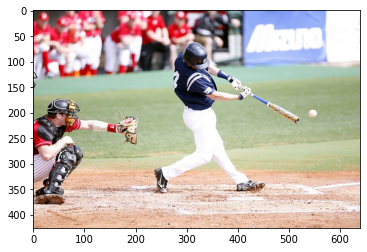

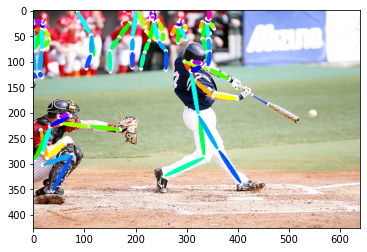

In [37]:
# from utils.decode_pose import decode_pose

_, result_img , _, _ = decode_pose(ori_image, heatmaps, pafs)

# 결과를 화면에 그리기
plt.imshow(ori_image)
plt.show()

plt.imshow(result_img)
plt.show()